<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/Fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SAR Application: Fire Extent Detection and Mapping
### I. How to create SAR quicklook images of fire extent?

* Useful Products: Polarimetric Synthetic Aperture Radar (PolSAR) products in the HH and HV polarizations, Pauli Decomposition images, dual-pol coomposites (HH, HV, HH/(HH+HV)), and InSAR coherence products
* Useful Wavelengths: L, S, C
* Instructions to View: Pauli decomposition for quad-pol data or HH/HV, VV/VH for dual-pol images

### II. How to interpret SAR images of fire extent?

The overlay of different polarization channels allows users to visually classify a scene by its backscattering mechanism, such as surface scattering (strong HH and VV return), volume scattering (strong HV return) and double-bounce scattering (strong HH return). RGB or "Red Green Blue" images, have these polarization channels encoded into different color channels, and the resulting color image can be employed to interpret physical information on the ground.

To identify burnt areas, compare the band ratios and Pauli Decomposition images from before and after the fire event, using the same scale to facilitate comparison. Area impacted by fire should show increase HH component (bare ground) and lower vegetation component (HV). In Pauli RGB images, areas dominated by green (HV) intensity are typically vegetated areas. Areas dominated by shades of pink (HH+HV) intensity are typically inundated forests, vegetated fields, or urban areas. Black and dark grey areas are usually smooth surfaces (roads, open water, smooth bare ground) where there is little radar backscatter.

Radar coherence images measure how well the phase signal is preserved between SAR acquisitions and can provide another method to detect areas of change. For a fire application, areas of lower coherence should correspond with the fire scar extent since changes in vegetation and other associated damage from the fire will cause decorrelation. For interpreting coherence products, compare image pairs with increasing temporal separation, until after a certain time between acquisitions when the entire image is decorrelated.

These grayscale coherence correlation products range from a scale of 0 to 1, where areas of decorrelation or disturbance approach 0. In a coherence map, darker areas have lower coherence or have decorrelated between acquisitions, as such, close to black areas are normally open water bodies that decorrelate the fastest, dark gray areas are regions decorrelated due to fire, and mid-gray and white have higher coherence or experienced less disturbance.

# 2017 La Tuna Fire Los Angeles, California


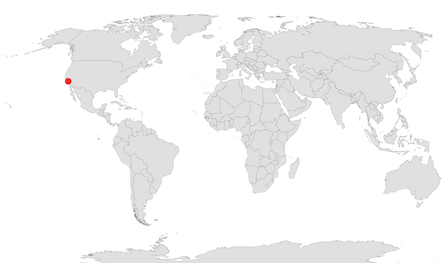

This Jupyter Notebook explores UAVSAR data over the 2017 La Tuna Fire in Los Angeles, California. Click on the underlined titles below to navigate to their section. The content of this notebook is as follows:

0. [Import Python Packages and Authenticate Notebook and data ](#s1)
1. [UAVSAR RGB Composite of La Tuna Fire](#s2)
2. [Create and Plot HV Transects](#s3)
3. [Time Series (dB)](#s4)


<a name="s1"></a>
## Running the Notebook
- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**. 
- Code cells that are required for the notebook to run without errors are marked numerically with <font color='red'> Run cell below </font> 

### Python Packages:
This routine uses the following python libraries. Some are already included in the Google Colab environment and others are installed in the cell below before imported. Downloading new python packages to this environment may take a few minutes to complete.

<font color='red'> 1. Run cell below </font> 

In [1]:
## The packages will take around a minute to install
!pip install rasterio --quiet
!pip install rasterstats --quiet
!pip install geopandas --quiet 
!pip install rioxarray --quiet

import rasterio as rio
import rasterio.plot
from rasterio.plot import show
import rasterstats as rs
from rasterio.plot import plotting_extent
from rasterio.mask import mask

import rioxarray as rxr ## gdal Readasarray equivalent

import geopandas as gpd
import pandas as pd
from geopandas import GeoDataFrame

from shapely.geometry import Point
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
import plotly.graph_objects as go

import numpy as np
from pathlib import Path
from skimage.measure import profile_line
import math

<a name="s2"></a>
# 1. UAVSAR RGB Composite of La Tuna Fire

The RGB UAVSAR images below show the September 2017 La Tuna Fire in the Verdugo Mountains, Los Angeles, California. The UAVSAR flightline SanAnd_08525 was acquired October 23, 2014 (Pre-fire) and November 02, 2017 (Post-fire). The fire perimeter extent is overlaid in red.

(Pre-Fire Top) 2014 Product Page: 
https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_14158_003_141023_L090_CX_01#data

(Post-Fire Bottom) 2017 Product Page: 
https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_17122_003_171102_L090_CX_01#data

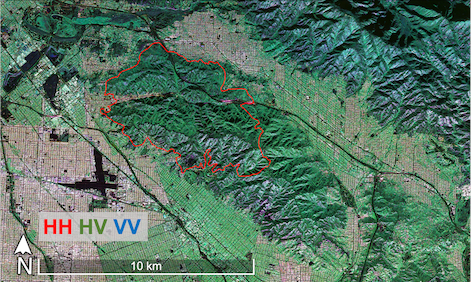

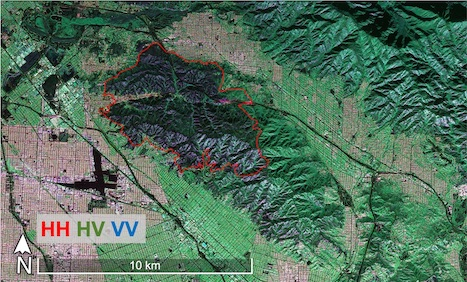

<a name="s3"></a>
## 2. Create and Plot HV Transects (Linear Power)
Below is a transect over the Verdugo mountains, spanning burned and unburned regions of the mountain range after the September 2017 La Tuna Fire. UAVSAR's HV polarization is used due to HV's sensitivity to vegetation change and transects from images pre and post fire can be uesd compare changes in HV backscatter values between areas burnt in the fire and unburnt areas. Burnt areas should have decreased HV backscatter.


First, read in UAVSAR Data and USGS Fire Severity Products

USGS Severity Products originally downloaded from: 

<font color='red'> 2. Run cell below </font> 

In [11]:
## UAVSAR Geotiffs
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/SanAnd_08525_14158_003_141023_L090HVHV_CX_01.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/SanAnd_08525_17122_003_171102_L090HVHV_CX_01.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/SanAnd_08525_stack.tif --quiet

## Auxiliary UAVSAR
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/SanAnd_08525_aspect_clip.tif  --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/SanAnd_08525_inc_clip.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/SanAnd_08525_stack.tif --quiet

## Perimeters
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/latuna_perimeter.geojson --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/unburnt_verdugo.geojson --quiet

## BARC Products
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/ca3429511836120170901_20170828_20170905_barc4.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/dnbr_20170828_20170905.tif --quiet

Then, use rasterio to open UAVSAR Data and geopandas to read in perimeter geojsons

<font color='red'> 3. Run cell below </font> 

In [3]:
def read_file(path):
  with rio.open(path) as ds:
    band = ds.read(1)
    return band

# Geotiffs
HV2014 = read_file('SanAnd_08525_14158_003_141023_L090HVHV_CX_01.tif')
HV2017 = read_file('SanAnd_08525_17122_003_171102_L090HVHV_CX_01.tif')
aspect = read_file('SanAnd_08525_aspect_clip.tif')
inc_angle = read_file('SanAnd_08525_inc_clip.tif')
barc4 = read_file('ca3429511836120170901_20170828_20170905_barc4.tif')
dnbr = read_file('dnbr_20170828_20170905.tif')
# GeoJsons
fire_perimeter = gpd.read_file('latuna_perimeter.geojson')
unburnt_perimeter = gpd.read_file('unburnt_verdugo.geojson')

Calculate Log Ratio for 2014 (Pre-Fire) & 2017 (Post-Fire)

Text(0.5, 1.0, 'HV Log Ratio 2014/2017')

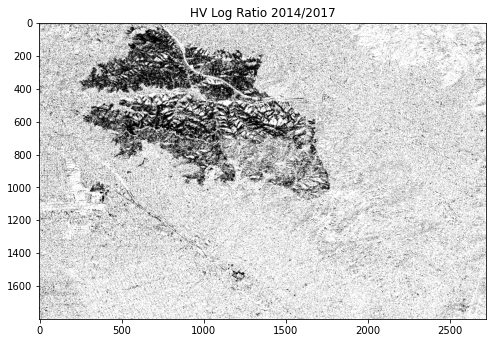

In [4]:
# Calculate the HV log ratio
np.seterr(divide='ignore', invalid='ignore')
HV_2014_2017 = np.divide(HV2014, HV2017)
HV_log_2014_2017= np.log10(HV_2014_2017)

# Plot the HV log ratio
r = HV_log_2014_2017
np.nanmin(r)
r[r > 1e308] = np.nan
r= r.astype('float32')

stddev=np.nanstd(r)
thres=1*stddev
mask=np.logical_and(r>-3*thres,r<thres)
masklr=~mask
mask = np.squeeze(mask)

fig,ax = plt.subplots(figsize=(8,16))
ax.imshow(mask,cmap='gray')
ax.set_title('HV Log Ratio 2014/2017')

Mask out local incidence angles less than 15 and greater than 75 degrees

Text(0.5, 1.0, 'HV Log Ratio 2014/2017')

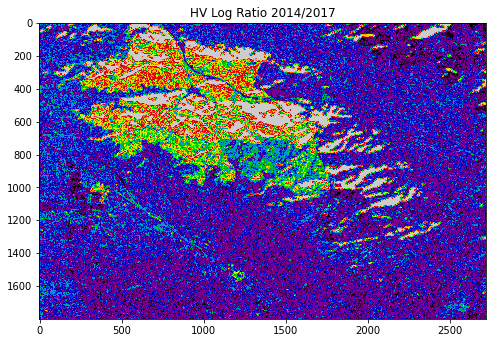

In [5]:
HV_log_2014_2017[inc_angle<0.296706]=np.nan #In radians
HV_log_2014_2017[inc_angle>1.22173]=np.nan

# Plot the HV log ratio
r = HV_log_2014_2017
np.nanmin(r)
r[r > 1e308] = np.nan
r= r.astype('float32')

stddev=np.nanstd(r)
thres=1*stddev
mask=np.logical_and(r>-3*thres,r<thres)
masklr=~mask
mask = np.squeeze(mask)

fig,ax = plt.subplots(figsize=(8,16))
ax.imshow(mask,cmap='nipy_spectral_r')
ax.set_title('HV Log Ratio 2014/2017')

UAVSAR Histograms


In [6]:
# import gdal
# import ogr
# driver = gdal.GetDriverByName('GTiff')
# test = gdal.Open('SanAnd_08525_14158_003_141023_L090HVHV_CX_01.tif')
# copy = driver.CreateCopy('copy.tif', test, 0)

# vec = ogr.Open('unburnt_verdugo.geojson')
# lyr = vec.GetLayer()
# gdal.RasterizeLayer(copy,[1],lyr)
# copy.GetRasterBand(1).SetNoDataValue(-1.0)
# copy = None

# burned = read_file('copy.tif')
# plt.imshow(burned, vmin=0, vmax=0.1)

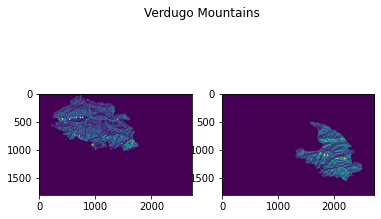

In [24]:
# Read in geojson files of the fire perimeter and the not burned portion of the Verdugo Mountains
perimeter = gpd.read_file('latuna_perimeter.geojson')
perimeter = perimeter["geometry"]

notburned = gpd.read_file('unburnt_verdugo.geojson')
notburned = notburned["geometry"]

# Using a raster as a source, mask to the burned and not burned portions of the Verdugo Mountains
with rio.open("SanAnd_08525_14158_003_141023_L090HVHV_CX_01.tif") as src:
   out_image, out_transform = rasterio.mask.mask(src, perimeter, crop=False)
   out_meta = src.meta
   notburned_image, notburned_transform = rasterio.mask.mask(src, notburned, crop=False)
   notburned_meta = src.meta   

# Specify the metadata
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
notburned_meta.update({"driver": "GTiff",
                 "height": notburned_image.shape[1],
                 "width": notburned_image.shape[2],
                 "transform": notburned_transform})
# Write the new files
with rio.open("latuna_perimeter.tif", "w", **out_meta) as dest:
    dest.write(out_image)
with rio.open("notburned_perimeter.tif", "w", **notburned_meta) as dest:
    dest.write(notburned_image)

# Read in and plot
img = read_file("latuna_perimeter.tif")
notburned_img = read_file("notburned_perimeter.tif")

fig, axs = plt.subplots(1,2)
fig.suptitle('Verdugo Mountains')
axs[0].imshow(img, vmin=0, vmax=0.1)
axs[1].imshow(notburned_img, vmin=0, vmax=0.1)

In [ ]:
fig = plt.figure(figsize=(15,10))

plt.hist(burned_logratio_2014_2017, bins=100, alpha=0.7, density=True,label="BURNED HV Log Ratio 2014-2017")
plt.hist(notburned_logratio_2014_2017, bins=100, alpha=0.7, density=True,label="NOT BURNED HV Log Ratio 2014-2017")
plt.legend(loc="upper left")
plt.show()

In [ ]:
# # UAVSAR Thresholding
# def find_bin_idx_of_value(bins, value):
#     """Finds the bin which the value corresponds to."""
#     array = np.asarray(value)
#     idx = np.digitize(array,bins)
#     return idx-1
# def area_after_val(counts, bins, val, color):
#     """Calculates the area of the hist after a certain value"""
#     left_bin_edge_index = find_bin_idx_of_value(bins, val)
#     bin_width = np.diff(bins)[0]
#     area = sum(bin_width * counts[left_bin_edge_index:])
#     return area
# def add_area_line_to_plot(axes, counts, bins, val, color):
#     """Adds a vertical line and labels it with the value and area after that line"""
#     area = area_after_val(counts, bins, val, color)
#     axes.axvline(val, color=color, label=f"val={val:.2f}, Area={area:.3f}")

# def main():
#     data = HV_log_2014_2017
#     fig, ax = plt.subplots()
#     counts, bins, _ = ax.hist(data, bins=200, alpha=0.3, density=True, range=(-0.2, 0.3), label="logratio_2014_2017")
#     add_area_line_to_plot(ax, counts, bins, val=0.1,color='r')   
#     add_area_line_to_plot(ax, counts, bins, val=0.2,color='r')  
#     add_area_line_to_plot(ax, counts, bins, val=0.207,color='r')
#     add_area_line_to_plot(ax, counts, bins, val=0.225,color='b') 
#     ax.legend()
#     plt.show()

# if __name__ == "__main__":
#     main() 

In [ ]:
# BAER Thresholding
# barc_256 = read_file('/Users/peacock/Desktop/LaTuna_Fire/Google_Drive/Aligned_30m/fire_severity_barc256_data_aligned.tif')
# barc_256 = barc_256[barc_256 != 0]

# fig = plt.figure(figsize=(15,10))

# def main():
# #     num_data_points, loc, scale = 1000, 40, 20
# #     data = np.random.normal(loc, scale,num_data_points)
#     data = barc_256
#     fig, ax = plt.subplots()
#     counts, bins, _ = ax.hist(data, bins=200, alpha=0.3, density=True, range=(77, 256), label="barc_256")
#     add_area_line_to_plot(ax, counts, bins, val=185,color='r')   
#     add_area_line_to_plot(ax, counts, bins, val=173.5,color='r') 
#     ax.legend()
#     plt.show()

# if __name__ == "__main__":
#     main()  

Next, convert to decibels (dB)

<font color='red'> 4. Run cell below </font> 

In [ ]:
## Convert to from linear power to decibels (dB)
## Formula: 10*log10(DN)
def convert_db(data):
  db = 10*(math.log10(data))
  return db

convert_db2 = np.vectorize(convert_db)

HV2014 = convert_db2(HV2014)
HV2017 = convert_db2(HV2017)

Then, specify pixel coordinates and transect width with "linewidth" and transect output values with "reduce_func"

<font color='red'> 5. Run cell below </font> 

In [ ]:
# Specify pixel coordinates
x0, y0 = 1300, 700
x1, y1 = 2200, 1300

# Specify transect
transect_2014 = profile_line(HV2014, (y0, x0), (y1, x1), linewidth=10, mode='nearest')#, reduce_func=np.median)
transect_2017 = profile_line(HV2017, (y0, x0), (y1, x1), linewidth=10, mode='nearest')#, reduce_func=np.median)

Finally, plot 2014 and 2017 data and transect

<font color='red'> 6. Run cell below </font> 

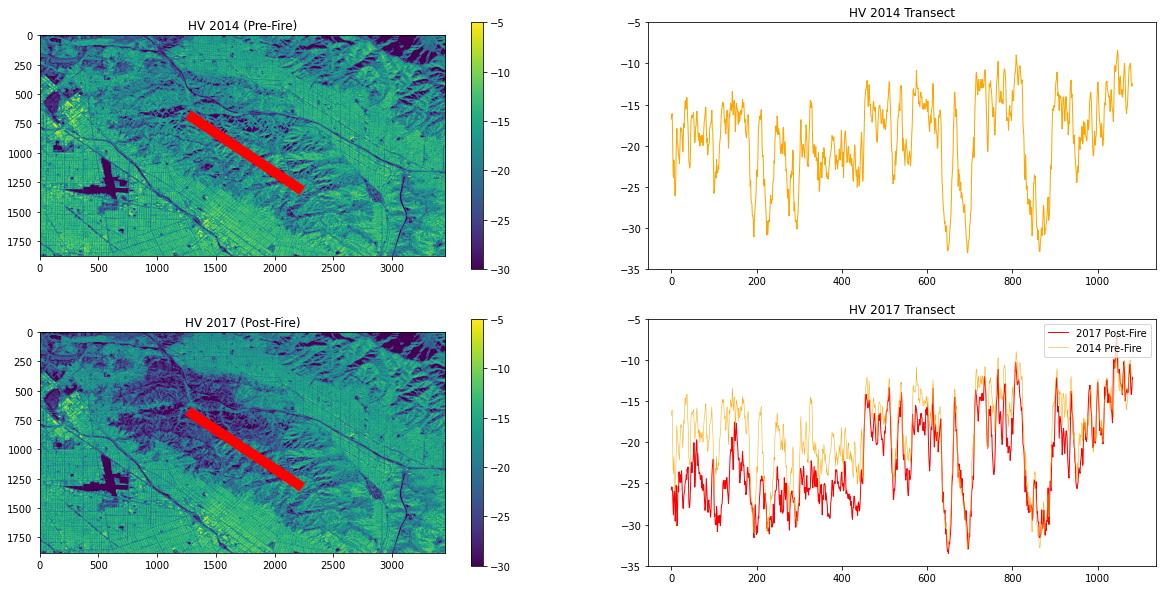

In [ ]:
#@title 2014 and 2017 decibel images and transect charts
# with rio.open('SanAnd_08525_14158_003_141023_L090HHHH_CX_01_cropped.grd.tif') as subset_src:
#     subset_extent = plotting_extent(subset_src)

# top_left_lon = -118.3907205000000147
# top_left_lat = 34.2716026200000101
# extent_mat = (top_left_lon, top_left_lon + subset_src.shape[1] * 0.00005556000000000000337, 
#               top_left_lat - subset_src.shape[0] * 0.00005556000000000000337, top_left_lat)

############## 2014 ##############
cm = ['viridis']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
color = axes[0,0].imshow(HV2014, vmin=-30, vmax=-5, cmap=cm[0])#, extent=extent_mat) 
axes[0,0].plot([x0, x1], [y0, y1], 'ro-', lw=10)
axes[0,0].set_title('HV 2014 (Pre-Fire)')
fig.colorbar(color, ax=axes[0,0])

axes[0,1].plot(transect_2014, color='orange', linewidth='1')
axes[0,1].set_ylim([-35, -5])
axes[0,1].set_title('HV 2014 Transect')

############## 2017 ##############
color = axes[1,0].imshow(HV2017, vmin=-30, vmax=-5, cmap=cm[0])#, extent=extent_mat)
axes[1,0].plot([x0, x1], [y0, y1], 'ro-', lw=10)
axes[1,0].set_title('HV 2017 (Post-Fire)')
fig.colorbar(color, ax=axes[1,0])

axes[1,1].plot(transect_2017, color='red', linewidth='1')
axes[1,1].plot(transect_2014, color='orange', linewidth='0.5')
axes[1,1].set_ylim([-35, -5])
axes[1,1].set_title('HV 2017 Transect')
plt.legend(('2017 Post-Fire', '2014 Pre-Fire'),
           loc='upper right')

plt.show()

<a name="s4"></a>
## 3. Time Series (dB)
Below are subsets from UAVSAR data collection extent over the Verdugo Mountains - half over the burned area and the other half dispersed over unburnt areas. In the HV and HH polarizations, variations in values are visible between burned and unburned subsets.

The UAVSAR stack read in below was converted from linear power to decibels (dB). Formula: 10*log10(DN)

First, read in stack of UAVSAR PolSAR data from 2009 and 2020.

<font color='red'> 7. Run cell below </font> 

In [ ]:
uavsar_stack = rio.open('SanAnd_08525_stack.tif')
img_stack = uavsar_bands

Then, read in shapefile of pre-selected buffered points around burnt and unburnt areas and plot buffered points on top of the UAVSAR image. This plot shows the distribution of points in relation to the study area. 

<font color='red'> 8. Run cell below </font> 

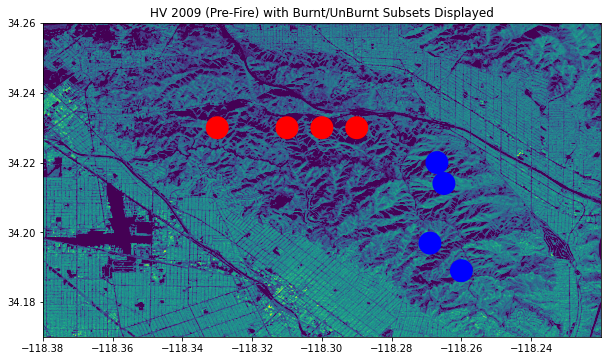

In [ ]:
## Read in shapefiles
gdf_buffer = 'gdf_buffer.shp'

gdf_plots = gpd.read_file(gdf_buffer)
gdf_burnt = gdf_plots[gdf_plots['fire']=='burnt']
gdf_notburnt = gdf_plots[gdf_plots['fire']=='notburnt']

## Plotting
fig, ax = plt.subplots(figsize=(10, 10))
cm = ['viridis']

ax = gdf_burnt.plot(ax=ax, facecolor='red', edgecolor='red', linewidth=2)
ax = gdf_notburnt.plot(ax=ax, facecolor='blue', edgecolor='blue', linewidth=2)
ax.set_title('HV 2009 (Pre-Fire) with Burnt/UnBurnt Subsets Displayed')

show((uavsar_stack, 1), ax=ax, vmin=-25, vmax=0, cmap=cm[0])

Extract mean and other statistics from areas of shapefile and raster overlap.

<font color='red'> 9. Run cell below </font> 

In [ ]:
#@title Raster Zonal Statistics
def zstats(vector, band, postfix):
    result = rs.zonal_stats(vector, uavsar_bands, band=band, stats='mean min max', geojson_out=True)
    for f in result:
        props = f['properties']
        props[postfix] = props.pop('mean')
        props = props[postfix]
        props2 = f['properties']
        props2[postfix] = props2.pop('max')
        props2 = props2[postfix]
        props3 = f['properties']
        props3[postfix] = props3.pop('min')
        props3 = props3[postfix]
        all = [props, props2, props3]
    return all

burnt_process = [
    (gdf_burnt, 1, '2009'),
    (gdf_burnt, 2, '2010'),
    (gdf_burnt, 3, '2011'),
    (gdf_burnt, 4, '2012'),
    (gdf_burnt, 5, '2014'),
    (gdf_burnt, 6, '2017'),
    (gdf_burnt, 7, '2018'),
    (gdf_burnt, 8, '2020')
]

notburnt_process = [
    (gdf_notburnt, 1, '2009'),
    (gdf_notburnt, 2, '2010'),
    (gdf_notburnt, 3, '2011'),
    (gdf_notburnt, 4, '2012'),
    (gdf_notburnt, 5, '2014'),
    (gdf_notburnt, 6, '2017'),
    (gdf_notburnt, 7, '2018'),
    (gdf_notburnt, 8, '2020')
]

burnt_stats = [zstats(*args) for args in burnt_process]
notburnt_stats = [zstats(*args) for args in notburnt_process]
years = ['2009','2010','2011','2012','2014','2017','2018','2020']

burnt_stats_df = pd.DataFrame(burnt_stats,columns=['burnt mean', 'burnt max','burnt min'])
notburnt_stats_df = pd.DataFrame(notburnt_stats, columns=['not burnt mean', 'not burnt max','not burnt min'])

/usr/local/lib/python3.7/dist-packages/rasterstats/io.py:302: UserWarning:

Setting nodata to -999; specify nodata explicitly



Print out data frame of Burnt vs. Non-Burnt mean, min, and max

<font color='red'> 10. Run cell below </font> 

In [ ]:
years = pd.Series(years, name="Year")
pd.to_datetime(years)
burnt_stats_df = pd.merge(years, burnt_stats_df, right_index=True, left_index=True)
burnt_stats_df = pd.merge(burnt_stats_df, notburnt_stats_df, right_index=True, left_index=True)

burnt_stats_df

,Year,burnt mean,burnt max,burnt min,not burnt mean,not burnt max,not burnt min
0,2009,-23.355330,-5.932755,-41.715858,-18.902123,-6.153824,-35.490726
1,2010,-23.172589,-6.953382,-41.617771,-18.258309,-5.647788,-35.282635
2,2011,-22.266615,-7.859430,-36.966049,-18.298684,-5.038753,-33.973343
3,2012,-22.353706,-6.629800,-36.821026,-18.395449,-4.563482,-34.874081
4,2014,-22.042698,-4.263805,-37.411942,-18.142646,-5.040717,-34.185871
5,2017,-27.028996,-9.001712,-37.978092,-18.375389,-6.055192,-33.777374
6,2018,-25.509915,-7.198468,-35.078541,-17.653546,-5.203991,-33.696453
7,2020,-25.932999,-7.830916,-36.895172,-17.088209,-5.383451,-31.470165


Finally, plot the time series. This time series plots the mean of the burnt and unburnt subsets from UAVSAR collections 2009 - 2020. At each acquisition point, the error bars extend plus and minus 25% of the data's spread.

<font color='red'> 11. Run cell below </font> 

In [ ]:
#@title Time Series Plot
######## Plot Time series ########
## Change so the spread is based on the min/max from the standard deviation

fig = go.Figure()
# fig.add_trace(go.Scatter(x=burnt_stats_df["Year"], y=burnt_stats_df["burnt mean"], name="Not Burnt", 
#                          error_y="burnt max", error_y_minus="burnt min"
#     ))

fig.add_trace(go.Scatter(x=burnt_stats_df["Year"], y=burnt_stats_df["burnt mean"], name="Burnt", error_y=dict(
            type='percent', # value of error bar given in data coordinates
            symmetric=False,
            value=25,
            valueminus=25)
    ))

fig.add_trace(go.Scatter(x=burnt_stats_df["Year"], y=burnt_stats_df["not burnt mean"], name="Not Burnt", error_y=dict(
            type='percent', # value of error bar given in data coordinates
            symmetric=False,
            value=25,
            valueminus=25)
    ))

fig.update_xaxes(
    dtick="M1",
    tickformat="\n%Y")

fig.update_layout(
    title="Burnt vs Unburnt HV Subsets over Fire Scar",
    xaxis_title="Year of UAVSAR Collection",
    yaxis_title="dB Power",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Black"
    )
)

fig.show()

#With matplotlib:
#plt.fill_between(range(100), mean-standard_dev, mean+standard_dev, alpha = 0.5)

## Data Download
UAVSAR Download: https://uavsar.jpl.nasa.gov/cgi-bin/data.p

ASF: https://search.asf.alaska.edu/#/

## Other Resources
NISAR Fire Applications White Paper: https://nisar.jpl.nasa.gov/system/documents/files/13_NISAR_Applications_Fire_Management1.pdf

ESA Document on Polarimetric Decompositions: https://earth.esa.int/documents/653194/656796/Polarimetric_Decompositions.pdf

Polarimetry: https://nisar.jpl.nasa.gov/mission/get-to-know-sar/polarimetry/

## References
“La Tuna Fire, City's Biggest by Acreage, Now 80% Contained, Officials Say.” Los Angeles Times, Los Angeles Times, 6 Sept. 2017, www.latimes.com/local/lanow/la-me-ln-verdugo-fire-containment-20170905-story.html.

Donnellan, Andrea, et al. “UAVSAR and Optical Analysis of the Thomas Fire Scar and Montecito Debris Flows: Case Study of Methods for Disaster Response Using Remote Sensing Products.” Earth and Space Science, vol. 5, no. 7, 2018, pp. 339–347., doi:10.1029/2018ea000398.

Ban, Y. et al. (2020) Near Real-Time Wildfire Progression Monitoring with Sentinel-1 SAR Time Series and Deep Learning. Nature Scientific Reports, 10 (1322).

California EPA (2021, January 8) Governor’s task force outlines actions to reduce wildfire rish, improve health of forests and wildlands. Accessed February 1, 2021.

Czuchlewski, K.R. and Weissel, J. K. (2005) Synthetic aperture radar (SAR)-based mapping of wildfire burn severity and recovery. Proceedings: 2005 IEEE International Geoscience and Remote Sensing Symposium.

Jung, J., et al. (2018) Damage-Mapping Algorithm Based on Coherence Model Using Multitemporal Polarimetric-Interferometric SAR Data. IEEE Transactions on Geoscience and Remote Sensing 56, 1520–1532.

NASA EarthData (2020, April 16) What is synthetic aperture radar? Accessed February 1, 2021.

NASA Jet Propulsion Laboratory (2021) What is UAVSAR? Accessed February 1, 2021.

NASA Jet Propulsion Laboratory (2020, September 15) NASA Takes Flight to Study California’s Wildfire Burn Areas. Accessed February 1, 2021.

Parker, J., Donnellan, A., & Glasscoe, M. (2021) Survey of Transverse Range Fire Scars in Ten Years of UAVSAR Polarimetry. Wiley.

Rains C. (2019) Detection of Fire Burn Scars by UAVSAR: Immediate, Short-term, and Multi-year Observations and Applications. NASA presentation.

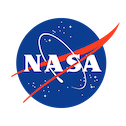

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2021. California Institute of Technology. Government sponsorship acknowledged. 